## Deep riccy project

## Colab dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! tar -zxvf /content/drive/MyDrive/Uni/DeepRiccy/refcocog.tar.gz

In [7]:
#set local path to the data

#this is for colab
#local_path = '/content/refcocog/images/'
#local_annotations = '/content/refcocog/annotations/'

#this is for local
local_path = './refcocog/images/' 
local_annotations = './refcocog/annotations/' 

## Dataset

In [8]:
#import section
import json
import pickle
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt



In [104]:
#class creation for the items
class CocogImage():
    def __init__(self, id, json_file, referece, refg):
        self.refg = refg
        self.id = id
        self.data = json_file['images'][id]
        self.bboxes = []
        self.img_id = self.data['id']

        for i in json_file['annotations']:
            if i['image_id'] == self.img_id:
                self.bboxes.append(i["bbox"])
                
        self.annotations = []

        for i in referece:
            if i['image_id'] == self.img_id:
                self.annotations.append(i["sentences"])
        
        self.refg = []
        for i in refg:
            if i['image_id'] == self.img_id:
                self.refg.append(i)
                    
    def show(self):
        img = Image.open(local_path + self.data['file_name'])
        plt.imshow(img)
        plt.show()

    def show_bbox(self):
        #print image with bbox
        img = self.get_image()
        plt.imshow(img)
        for i in self.bboxes:
            plt.gca().add_patch(plt.Rectangle((i[0], i[1]), i[2], i[3], fill=False, edgecolor='red', linewidth=2))
        plt.show()

    def get_image_tensor(self, transform = transforms.Compose([transforms.PILToTensor()])):
        img = Image.open(local_path + self.data['file_name'])
        return transform(img)
    
    def get_image(self):
        return Image.open(local_path + self.data['file_name'])

    def file_name(self):
        return local_path+self.data['file_name']

    def id(self):
        return self.data['id']

    def width(self):
        return self.data['width']

    def height(self):
        return self.data['height']

    def bbox(self):
        return self.bboxes
    
    def annotations(self):
        return self.annotations

In [99]:
class Coco(Dataset):
  def __init__(self, size):
    super(Coco, self).__init__()
    self.size = size
    #load json file
    with open(local_annotations + 'instances.json', 'r') as f:
      self.data = json.load(f)
    #load references(umd)
    with open(local_annotations + 'refs(umd).p', 'rb') as f:
      self.references = pickle.load(f)
      f.close()
    #load references(google)
    with open(local_annotations + 'refs(google).p', 'rb') as f:
      self.references_google = pickle.load(f)
      f.close()
    
    
  def __getitem__(self, idx):
    if idx >= self.size:
      raise IndexError()
    #import image form json
    image = CocogImage(idx, self.data, self.references, self.references_google)
    return image
    
    return image.get_image(), image.bbox(), image.annotations()

  def __len__(self):
    return self.size


## Model

In [100]:
#test
dataset = Coco(100)

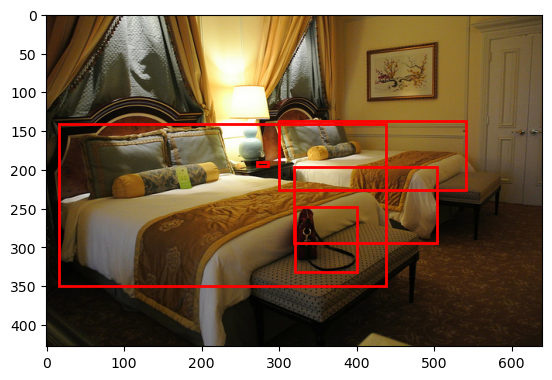

In [101]:
#print the first image
dataset[0].show_bbox()

### Test dataset and show bboxes

In [103]:
#get how many annotation have the img_id equal to 131074
count = 0

for i in dataset.refg:
  if i['image_id'] == 131074:
    count += 1
print(count)

AttributeError: 'Coco' object has no attribute 'refg'

In [57]:
with open(local_annotations + 'refs(umd).p', 'rb') as f:
      references = pickle.load(f)

print(references[0])

{'image_id': 380440, 'split': 'test', 'sentences': [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'], 'raw': 'the man in yellow coat', 'sent_id': 8, 'sent': 'the man in yellow coat'}, {'tokens': ['skiier', 'in', 'red', 'pants'], 'raw': 'Skiier in red pants.', 'sent_id': 9, 'sent': 'skiier in red pants'}], 'file_name': 'COCO_train2014_000000380440_491042.jpg', 'category_id': 1, 'ann_id': 491042, 'sent_ids': [8, 9], 'ref_id': 0}


In [97]:
#find in the pickle file the annotation with img_id 131074
for i in dataset.refg:
  if i['image_id'] == 131074:
    print(i)

AttributeError: 'Coco' object has no attribute 'refg'

### yolo

In [9]:
#install dependencies
! pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-4-12 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 74.3MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 428x6

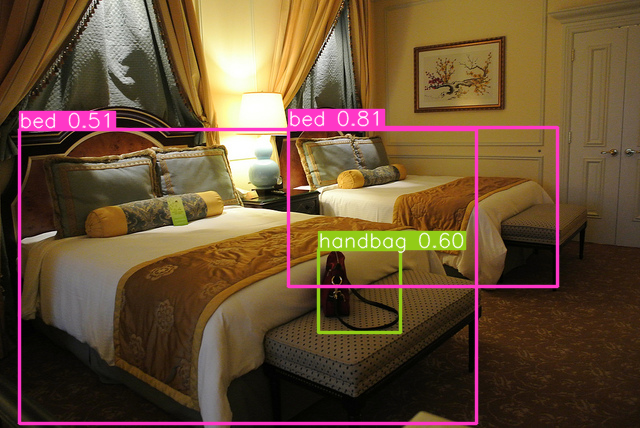

xmin        ymin        xmax        ymax  confidence  class     name
0  288.968994  127.100845  557.273315  286.947144    0.808232     59      bed
1  318.245178  249.163605  400.886963  332.597382    0.599789     26  handbag
2   19.502380  129.520203  476.208862  423.893616    0.510607     59      bed

In [10]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = dataset[0].file_name() 
# Inference
results = model(imgs)

# Results
results.print()
results.show()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)

## Clip implementation

In [11]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6bc6bmdc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6bc6bmdc
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=3260e74d2b00a2ccf5eb951d8271b4c1e81b79bb8a3223463070b571706b4b02
  Stored in directory: /tmp/pip-ephem-wheel-cache-knyiw_s2/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [12]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.0.0+cu118


In [13]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [14]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 146MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [15]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

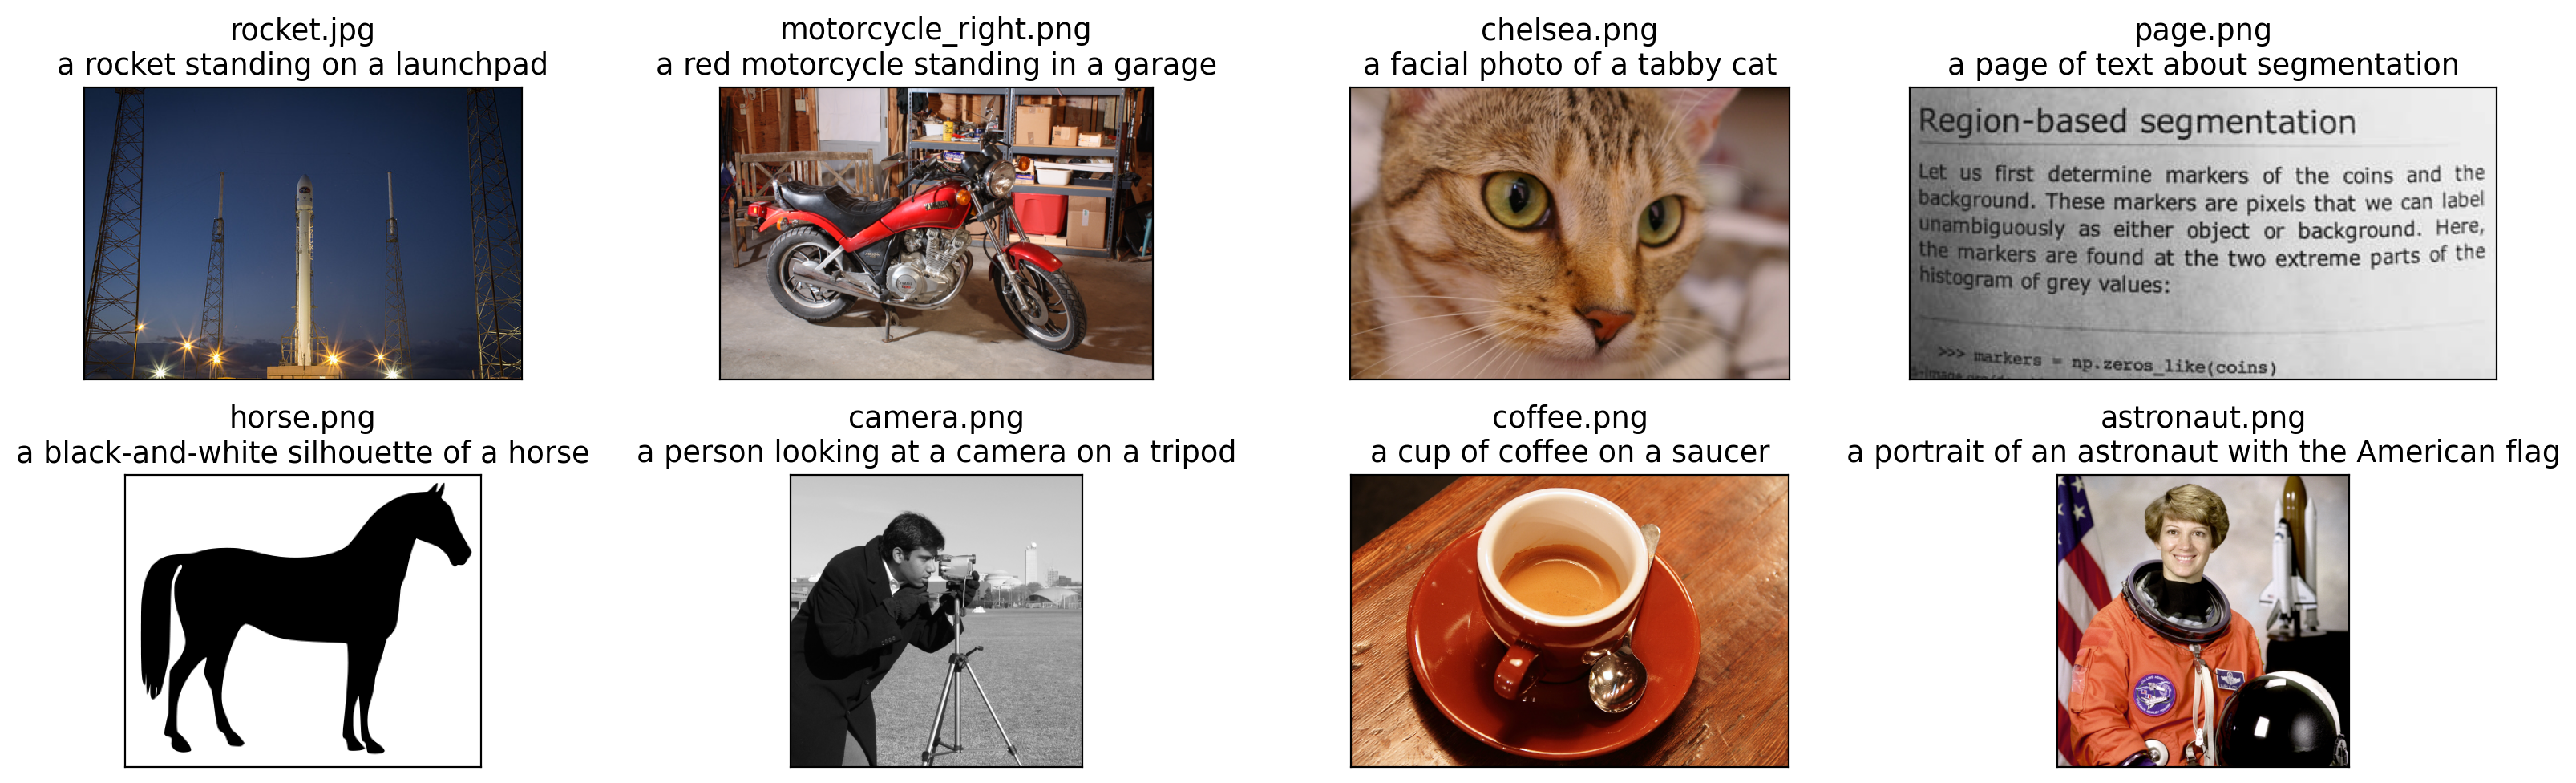

In [16]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [17]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [18]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [19]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

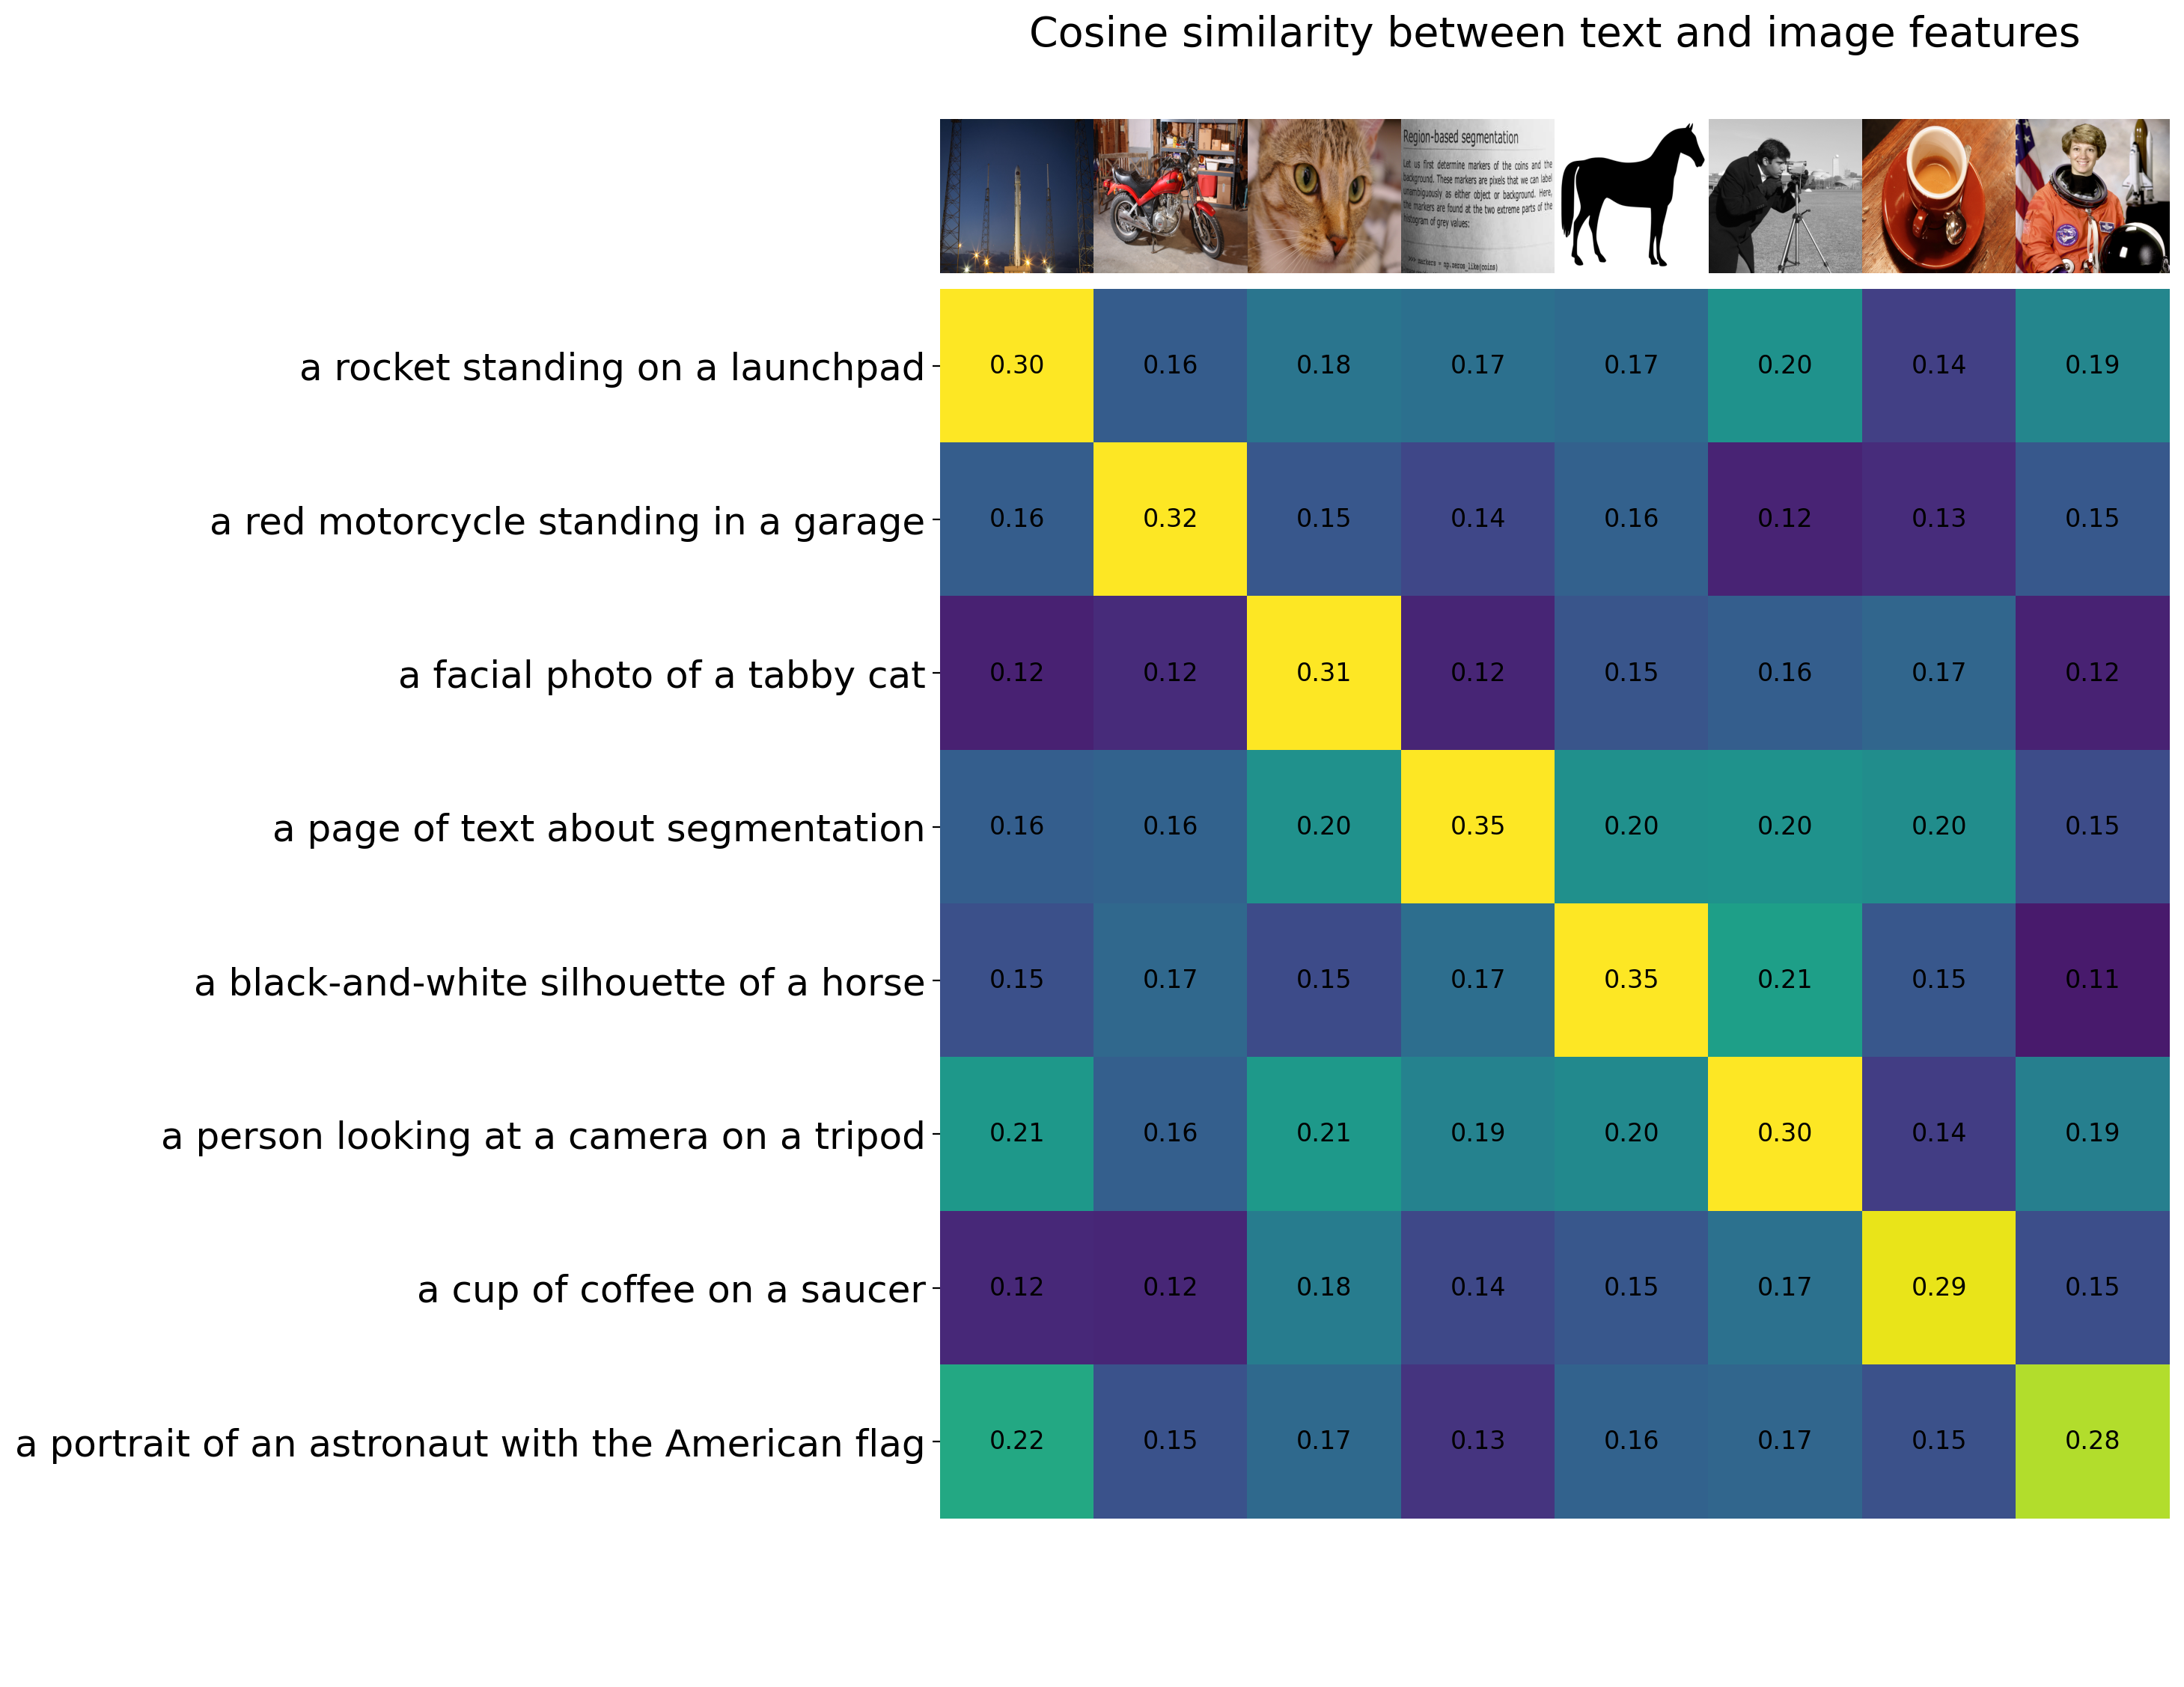

In [20]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)